In [24]:
pip install prophet

Note: you may need to restart the kernel to use updated packages.


Install and import necessary libraries

In [1]:
#Pandas - provides data structures like Series and DataFrames
import pandas as pd
#Numpy - support for arrays, matrices, and a variety of mathematical functions to operate on these data structures
import numpy as np
#matplotlib - provides a MATLAB-like interface for plotting
import matplotlib.pyplot as plt
#The Prophet library, developed by Meta (formerly Facebook), is a powerful open-source tool designed for time-series forecasting
from prophet import Prophet

In [2]:
#MAE-Measures the average absolute difference between predicted and actual values,MAPE-Measures the percentage difference between predicted and actual values
#R2-Measures how well the regression model explains the variability
from sklearn.metrics import mean_absolute_error,  mean_absolute_percentage_error, r2_score

Data cleaning

In [6]:
import pandas as pd
import numpy as np

def load_daily_data(file_path):
    # Read the CSV file with appropriate column names
    df = pd.read_csv(file_path, sep=';', header=None, 
                     names=['Year', 'Month', 'Day', 'Fractional_Year', 'Sunspots', 'Std_Dev', 'Obs', 'Definitive'])
    
    # Create a datetime index using Year, Month, and Day columns
    df['Date'] = pd.to_datetime(df[['Year', 'Month', 'Day']])
    
    # Set 'Date' as the index
    df.set_index('Date', inplace=True)
    
    # Convert 'Sunspots' to numeric, replacing any non-numeric values with NaN
    df['Sunspots'] = pd.to_numeric(df['Sunspots'], errors='coerce')
    
    # Remove any rows with NaN sunspot values
    df_cleaned = df[['Sunspots']].dropna()
    
    # Remove any rows with negative sunspot values (indicating missing data)
    df_cleaned = df_cleaned[df_cleaned['Sunspots'] >= 0]
    
    print("Columns:", df_cleaned.columns)
    print("Data cleaned:")
    print(df_cleaned.head())
    print("\nSummary:")
    print(df_cleaned.describe())
    
    return df_cleaned

# Specify the file path for the daily dataset
file_path = 'C:/Users/harin/OneDrive/Desktop/MS DS College stuffs/CS675 Intro To DS/Assignment 3/SN_d_tot_V2.0.csv'
daily_data = load_daily_data(file_path)

Columns: Index(['Sunspots'], dtype='object')
Data cleaned:
            Sunspots
Date                
1818-01-08        65
1818-01-13        37
1818-01-17        77
1818-01-18        98
1818-01-19       105

Summary:
           Sunspots
count  71383.000000
mean      82.200006
std       77.113175
min        0.000000
25%       20.000000
50%       62.000000
75%      127.000000
max      528.000000


Time unit detection

Create a date column, check for consistency

In [4]:
def determine_time_unit(data):
    if isinstance(data, pd.DataFrame) and 'Date' in data.columns:
        date_column = data['Date']
    elif isinstance(data, pd.Series):
        date_column = data
    else:
        raise ValueError("Input must be a pandas DataFrame with a 'Date' column or a Series")

    # Ensure date_column is in datetime format
    date_column = pd.to_datetime(date_column, errors='coerce')

    # Calculate time differences
    time_diff = date_column.diff().dropna()
    
    # Check if the time difference is consistently 1 day
    if np.allclose(time_diff.dt.days, 1, atol=1e-2):
        return 'daily'
    else:
        return 'irregular'

# Read the CSV file
file_path = 'C:/Users/harin/OneDrive/Desktop/MS DS College stuffs/CS675 Intro To DS/Assignment 3/SN_d_tot_V2.0.csv'
data = pd.read_csv(file_path, sep=';', header=None, 
                   names=['Year', 'Month', 'Day', 'Date', 'Value1', 'Value2', 'Value3', 'Value4'])

# Convert Date to datetime
data['Date'] = pd.to_datetime(data['Year'].astype(str) + '-' + 
                              data['Month'].astype(str) + '-' + 
                              data['Day'].astype(str), format='%Y-%m-%d')

time_unit = determine_time_unit(data)
print(f"The time series is {time_unit}")

# No need to convert to daily dataset as it's already daily
daily_data = data

daily_time_unit = determine_time_unit(daily_data)
print(f"The converted time series is {daily_time_unit}")

# Display the first few rows of the daily dataset
print(daily_data.head())



The time series is daily
The converted time series is daily
   Year  Month  Day       Date  Value1  Value2  Value3  Value4
0  1818      1    1 1818-01-01      -1    -1.0       0       1
1  1818      1    2 1818-01-02      -1    -1.0       0       1
2  1818      1    3 1818-01-03      -1    -1.0       0       1
3  1818      1    4 1818-01-04      -1    -1.0       0       1
4  1818      1    5 1818-01-05      -1    -1.0       0       1


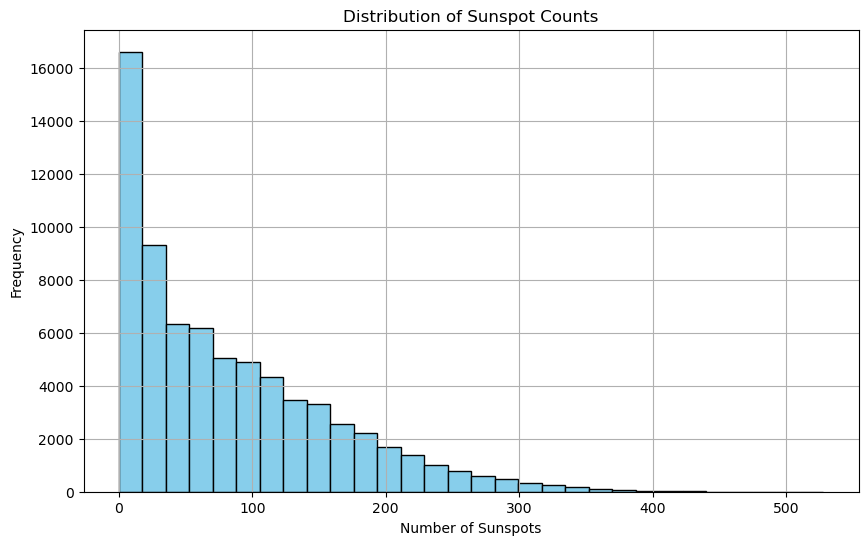

In [7]:

# Plot histogram to see the distribution of Sunspot counts
plt.figure(figsize=(10, 6))
plt.hist(daily_data['Sunspots'], bins=30, color='skyblue', edgecolor='black')
plt.title('Distribution of Sunspot Counts')
plt.xlabel('Number of Sunspots')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [17]:
import pandas as pd

# Load the dataset
daily_data = pd.read_csv('C:/Users/harin/OneDrive/Desktop/MS DS College stuffs/CS675 Intro To DS/Assignment 3/SN_d_tot_V2.0.csv', 
                         header=None, names=['Year', 'Month', 'Day', 'DecimalDate', 'Sunspots', 'StdDev', 'Observations', 'Indicator'], sep=';')

# Verify the column names
print(daily_data.columns)  # Check if the column names are correct

# Create a datetime column from Year, Month, and Day
daily_data['ds'] = pd.to_datetime(daily_data[['Year', 'Month', 'Day']])

# Use the 'Sunspots' column for the 'y' column (sunspot numbers)
daily_data['y'] = daily_data['Sunspots']

# Replace missing values (-1) with NaN and drop rows with NaN values
daily_data['y'].replace(-1, pd.NA, inplace=True)
daily_data.dropna(subset=['y'], inplace=True)

# Set 'ds' as the index
daily_data.set_index('ds', inplace=True)

# Find the row with the maximum sunspot value
max_sunspot_day = daily_data[daily_data['Sunspots'] == daily_data['Sunspots'].max()]

# Print the date and sunspot value for the maximum
print("Day with the most Sunspots:")
print(max_sunspot_day[['Sunspots']])


Index(['Year', 'Month', 'Day', 'DecimalDate', 'Sunspots', 'StdDev',
       'Observations', 'Indicator'],
      dtype='object')
Day with the most Sunspots:
            Sunspots
ds                  
1870-08-26       528


C:\Users\harin\AppData\Local\Temp\ipykernel_29376\3419798086.py:17: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  daily_data['y'].replace(-1, pd.NA, inplace=True)


In [18]:
mean_sunspots = daily_data['Sunspots'].mean()
median_sunspots = daily_data['Sunspots'].median()
print(f"Mean Sunspot count: {mean_sunspots}")
print(f"Median Sunspot count: {median_sunspots}")

Mean Sunspot count: 82.20000560357508
Median Sunspot count: 62.0


 train your model into the future

C:\Users\harin\AppData\Local\Temp\ipykernel_29376\1269627789.py:19: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['y'].replace(-1, pd.NA, inplace=True)
15:52:44 - cmdstanpy - INFO - Chain [1] start processing
15:54:40 - cmdstanpy - INFO - Chain [1] done processing


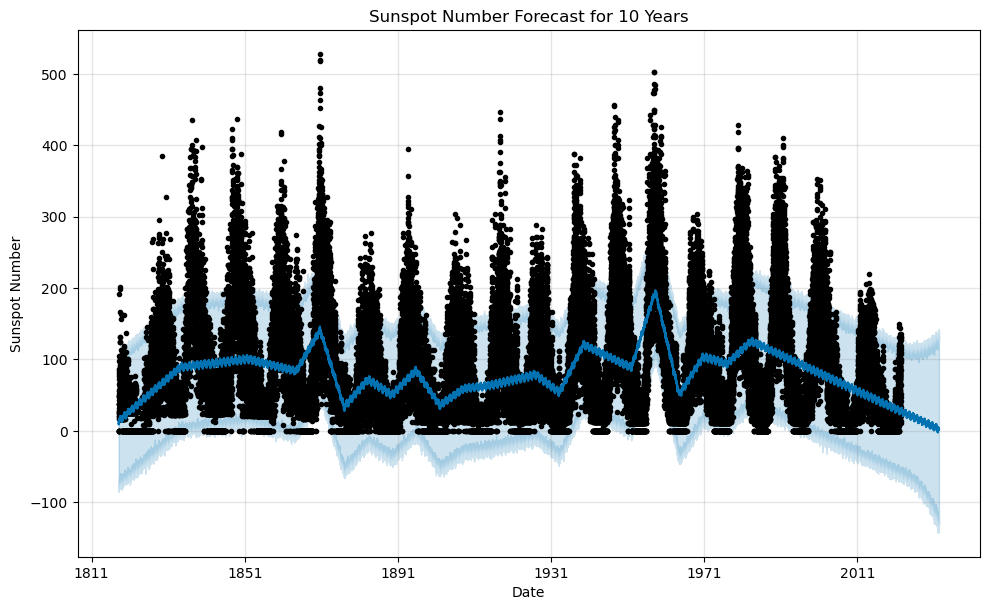

Future Predictions (Last 5 rows):
              ds      yhat  yhat_lower  yhat_upper
75028 2032-04-23  3.046060 -122.849979  127.829289
75029 2032-04-24  3.064763 -125.017861  129.428121
75030 2032-04-25  2.611098 -130.321323  132.317169
75031 2032-04-26  2.378264 -126.373491  132.535014
75032 2032-04-27  2.050900 -121.028078  131.295707

Prediction for 100 day(s):
Date: 2022-08-08 00:00:00
Predicted Sunspots: 29.23
Confidence Interval: [-60.03, 112.55]


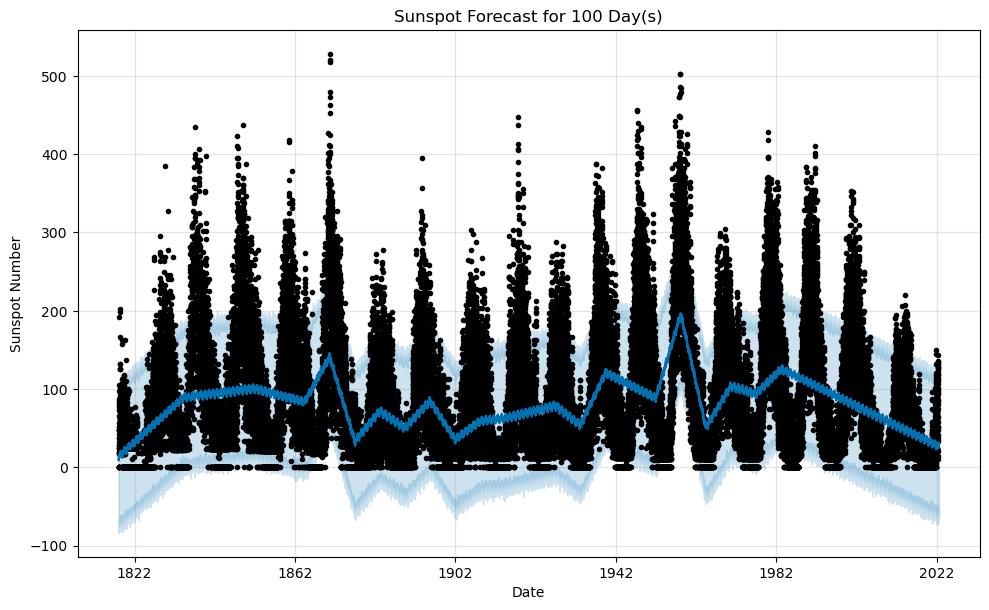


Prediction for 200 day(s):
Date: 2022-11-16 00:00:00
Predicted Sunspots: 23.63
Confidence Interval: [-69.64, 108.16]


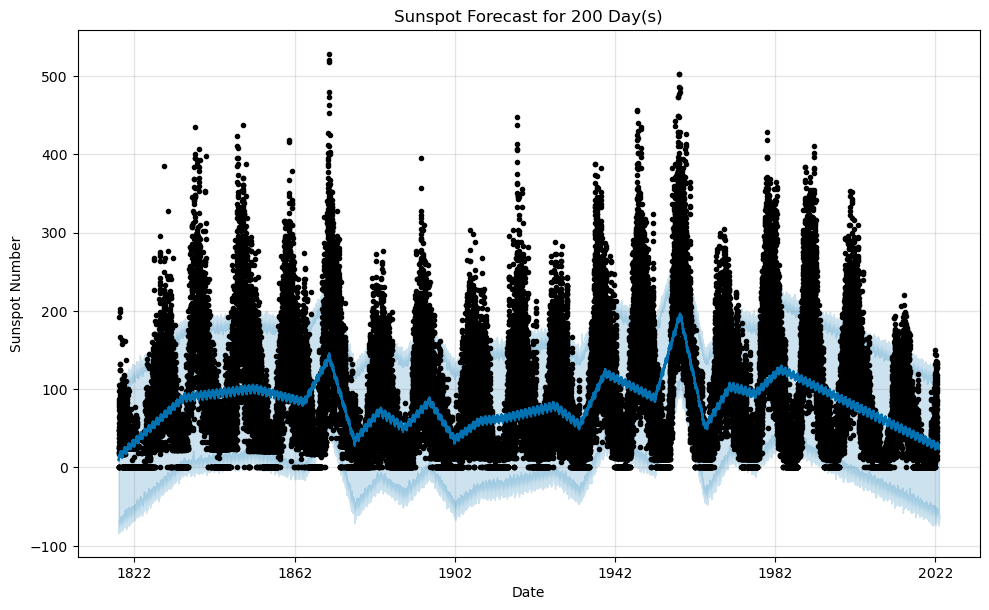


Prediction for 365 day(s):
Date: 2023-04-30 00:00:00
Predicted Sunspots: 26.61
Confidence Interval: [-57.37, 123.08]


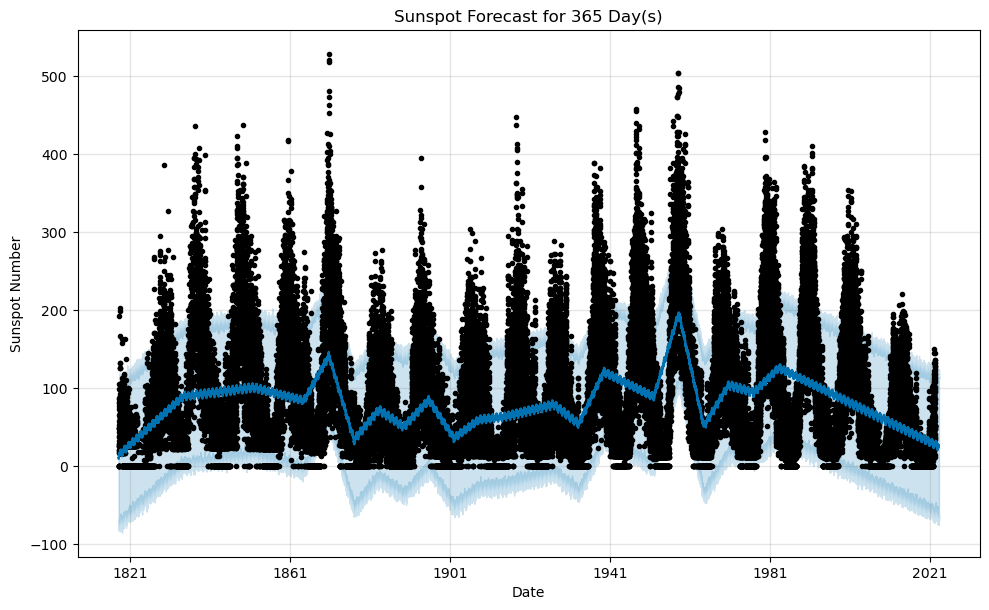

In [2]:
# Import necessary libraries
import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt

# Load and preprocess the data
file_path = 'C:/Users/harin/OneDrive/Desktop/MS DS College stuffs/CS675 Intro To DS/Assignment 3/SN_d_tot_V2.0.csv'  
data = pd.read_csv(file_path, delimiter=';', header=None)

# Assign column names based on the dataset description
data.columns = ['Year', 'Month', 'Day', 'Date Fraction', 'Sunspot Number', 'Standard Deviation', 
                'Observation Count', 'Definitive Indicator']

# Create a date column
data['ds'] = pd.to_datetime(data[['Year', 'Month', 'Day']])
data['y'] = data['Sunspot Number']

# Replace missing values (-1) with NaN and drop rows with NaN values
data['y'].replace(-1, pd.NA, inplace=True)
data.dropna(subset=['y'], inplace=True)

# Instantiate and configure Prophet model
model = Prophet(growth='linear', yearly_seasonality=True, daily_seasonality=True)
model.add_seasonality(name='monthly', period=30.5, fourier_order=5)

# Train the model
model.fit(data[['ds', 'y']])

# Function to predict and visualize for a specific period
def forecast_sunspots(periods, freq='D'):
    # Create future dataframe
    future = model.make_future_dataframe(periods=periods, freq=freq)
    
    # Predict future values
    forecast = model.predict(future)
    
    # Extract specific prediction
    prediction = forecast.iloc[-1][['ds', 'yhat', 'yhat_lower', 'yhat_upper']]
    
    # Print result
    print(f"\nPrediction for {periods} day(s):")
    print(f"Date: {prediction['ds']}")
    print(f"Predicted Sunspots: {prediction['yhat']:.2f}")
    print(f"Confidence Interval: [{prediction['yhat_lower']:.2f}, {prediction['yhat_upper']:.2f}]")
    
    # Plot the forecast
    fig = model.plot(forecast)
    plt.title(f'Sunspot Forecast for {periods} Day(s)')
    plt.xlabel('Date')
    plt.ylabel('Sunspot Number')
    plt.show()

# Extend the dataset into the future
def extend_data_future(data, years_to_extend=10):
    # Generate future dates based on the maximum date in the dataset
    last_date = data['ds'].max()
    future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), 
                                 periods=years_to_extend * 365, 
                                 freq='D')
    # Create a new DataFrame for future dates with placeholder values
    future_data = pd.DataFrame({'ds': future_dates})
    return pd.concat([data, future_data], ignore_index=True)

# Extend the dataset by 10 years into the future
extended_data = extend_data_future(data, years_to_extend=10)

# Forecast future values
future = model.make_future_dataframe(periods=10 * 365, freq='D')  # Predict for 10 years
forecast = model.predict(future)

# Plot the forecast
fig = model.plot(forecast)
plt.title('Sunspot Number Forecast for 10 Years')
plt.xlabel('Date')
plt.ylabel('Sunspot Number')
plt.show()

# Display the future forecast results
forecast_tail = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()
print("Future Predictions (Last 5 rows):")
print(forecast_tail)

# Predict for 100, 200, and 365 days separately
forecast_sunspots(100)
forecast_sunspots(200)
forecast_sunspots(365)


Model tuning - Forecasting growth


C:\Users\harin\AppData\Local\Temp\ipykernel_38244\163606427.py:13: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  daily_dataset['y'].replace(-1, pd.NA, inplace=True)
16:53:10 - cmdstanpy - INFO - Chain [1] start processing
16:53:12 - cmdstanpy - INFO - Chain [1] done processing


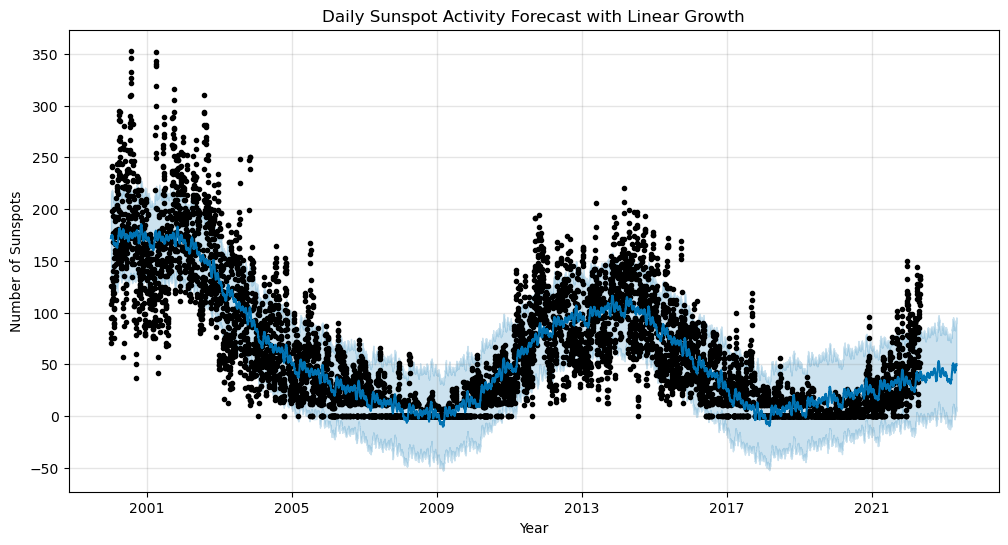

16:53:14 - cmdstanpy - INFO - Chain [1] start processing
16:53:14 - cmdstanpy - INFO - Chain [1] done processing


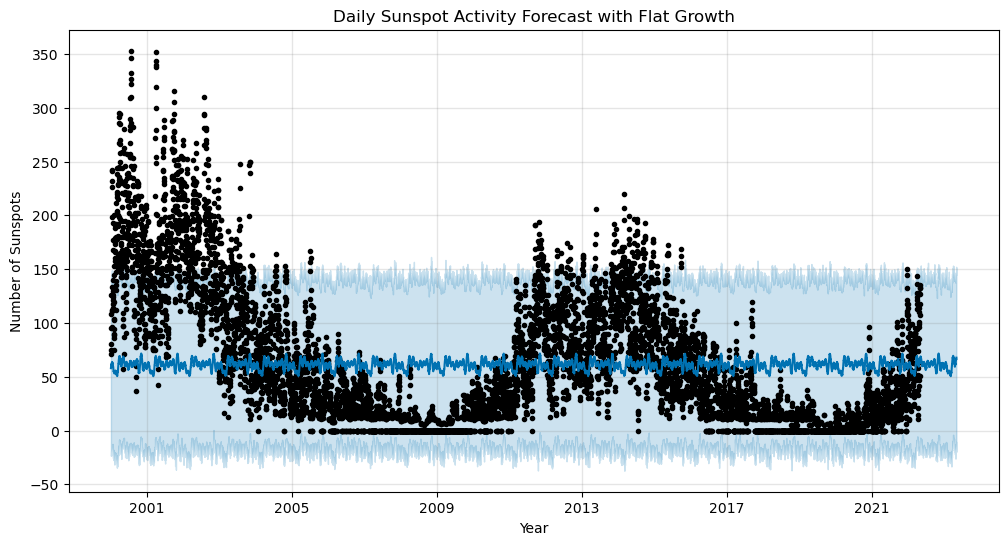

16:53:16 - cmdstanpy - INFO - Chain [1] start processing
16:53:18 - cmdstanpy - INFO - Chain [1] done processing


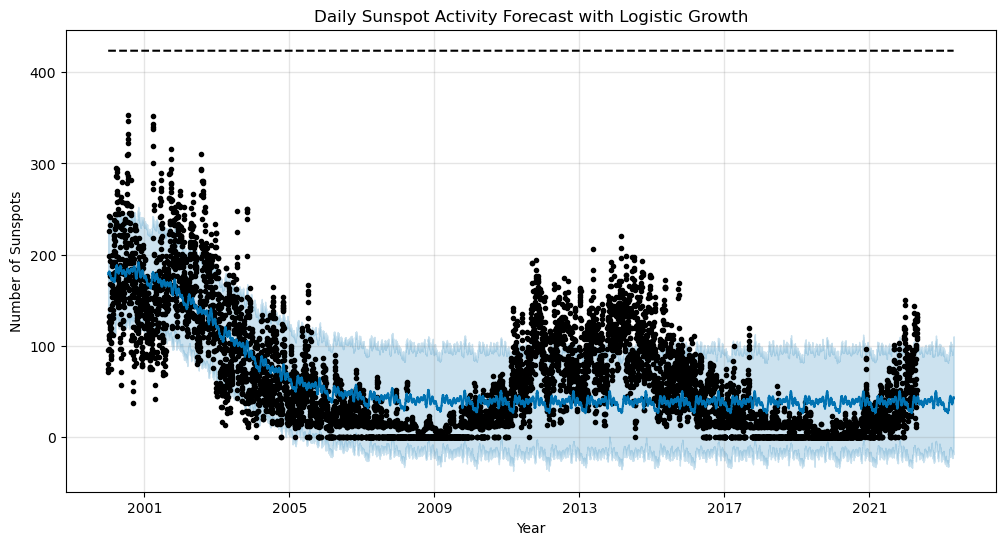

Linear Growth Forecast:
             ds       yhat
8516 2023-04-26  48.292622
8517 2023-04-27  48.827437
8518 2023-04-28  49.209387
8519 2023-04-29  48.447949
8520 2023-04-30  50.139374

Flat Growth Forecast:
             ds       yhat
8516 2023-04-26  65.684934
8517 2023-04-27  66.233028
8518 2023-04-28  66.628821
8519 2023-04-29  65.978536
8520 2023-04-30  67.703176

Logistic Growth Forecast:
             ds       yhat
8516 2023-04-26  41.860270
8517 2023-04-27  42.373879
8518 2023-04-28  42.734797
8519 2023-04-29  41.946784
8520 2023-04-30  43.618635


In [2]:
import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt

# Load the daily dataset
daily_dataset = pd.read_csv('C:/Users/harin/OneDrive/Desktop/MS DS College stuffs/CS675 Intro To DS/Assignment 3/SN_d_tot_V2.0.csv', header=None, names=['Year', 'Month', 'Day', 'DecimalDate', 'Sunspots', 'StdDev', 'Observations', 'Indicator'], sep=';')

# Create a datetime column from Year, Month, and Day
daily_dataset['ds'] = pd.to_datetime(daily_dataset[['Year', 'Month', 'Day']])
daily_dataset['y'] = daily_dataset['Sunspots']

# Replace missing values (-1) with NaN and drop rows with NaN values
daily_dataset['y'].replace(-1, pd.NA, inplace=True)
daily_dataset.dropna(subset=['y'], inplace=True)

# Filter the dataset to include only data from the year 2000 onwards
df = daily_dataset[daily_dataset['ds'] >= '2000-01-01'][['ds', 'y']]

# Function to create and plot forecast
def create_forecast(growth_type, periods=365, cap=None):
    if growth_type == 'logistic':
        df['cap'] = cap
        m = Prophet(growth='logistic', daily_seasonality=True)
    else:
        m = Prophet(growth=growth_type, daily_seasonality=True)
    
    m.fit(df)
    
    future = m.make_future_dataframe(periods=periods, freq='D')
    if growth_type == 'logistic':
        future['cap'] = cap
    
    forecast = m.predict(future)
    
    fig = plt.figure(figsize=(12, 6))
    m.plot(forecast, ax=plt.gca())
    plt.title(f'Daily Sunspot Activity Forecast with {growth_type.capitalize()} Growth')
    plt.xlabel('Year')
    plt.ylabel('Number of Sunspots')
    plt.show()
    
    return forecast

# Create forecasts for different growth types
linear_forecast = create_forecast('linear')
flat_forecast = create_forecast('flat')
logistic_forecast = create_forecast('logistic', cap=df['y'].max() * 1.2)

# Print the last 5 days of each forecast
print("Linear Growth Forecast:")
print(linear_forecast[['ds', 'yhat']].tail())
print("\nFlat Growth Forecast:")
print(flat_forecast[['ds', 'yhat']].tail())
print("\nLogistic Growth Forecast:")
print(logistic_forecast[['ds', 'yhat']].tail())


Seasonality

This approach allows you to forecast daily sunspot numbers by incorporating custom seasonality periods (e.g., annual, solar cycle) 
and adjusting the flexibility of the seasonal patterns using Fourier terms

C:\Users\harin\AppData\Local\Temp\ipykernel_38244\4082965670.py:15: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  daily_dataset['y'].replace(-1, pd.NA, inplace=True)
16:58:47 - cmdstanpy - INFO - Chain [1] start processing
16:58:49 - cmdstanpy - INFO - Chain [1] done processing


<Figure size 1200x600 with 0 Axes>

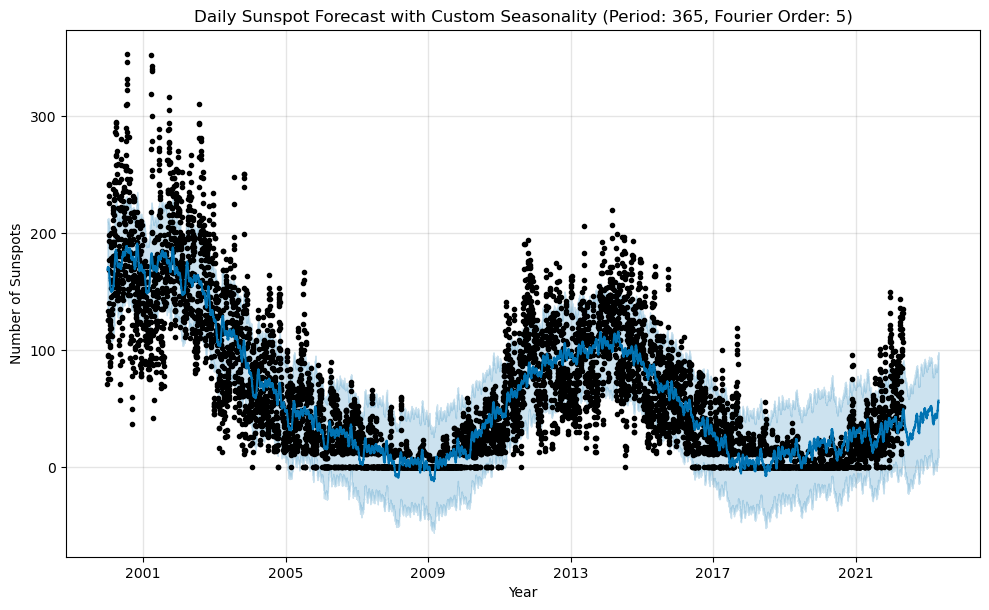


Forecast for Period: 365 days, Fourier Order: 5
             ds       yhat
8516 2023-04-26  53.904017
8517 2023-04-27  54.752171
8518 2023-04-28  55.410324
8519 2023-04-29  54.888133
8520 2023-04-30  56.780470


16:58:52 - cmdstanpy - INFO - Chain [1] start processing
16:58:54 - cmdstanpy - INFO - Chain [1] done processing


<Figure size 1200x600 with 0 Axes>

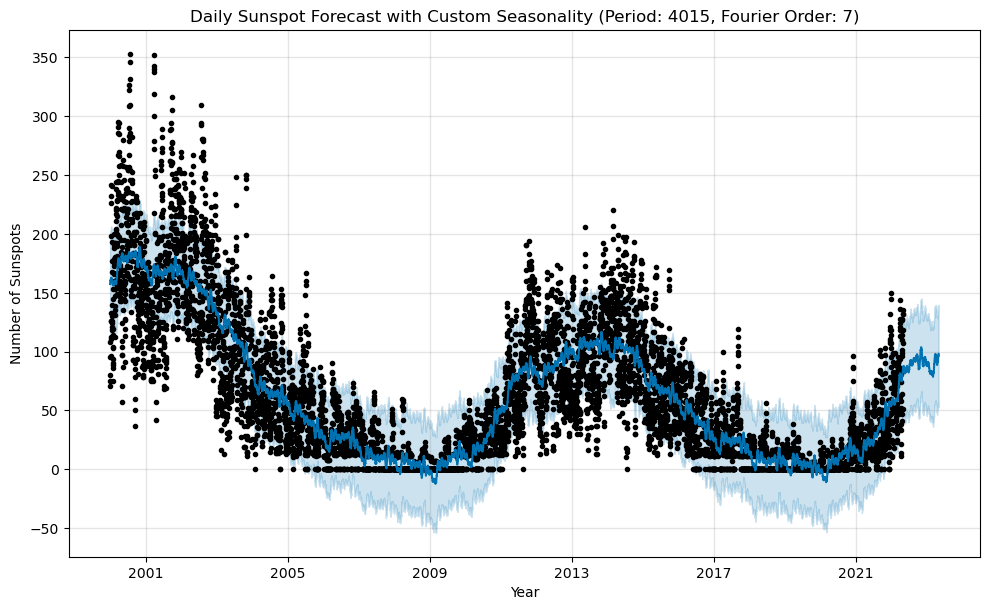


Forecast for Period: 4015 days, Fourier Order: 7
             ds       yhat
8516 2023-04-26  95.693203
8517 2023-04-27  96.331962
8518 2023-04-28  96.822860
8519 2023-04-29  96.186549
8520 2023-04-30  98.030792


16:58:56 - cmdstanpy - INFO - Chain [1] start processing
16:58:57 - cmdstanpy - INFO - Chain [1] done processing


<Figure size 1200x600 with 0 Axes>

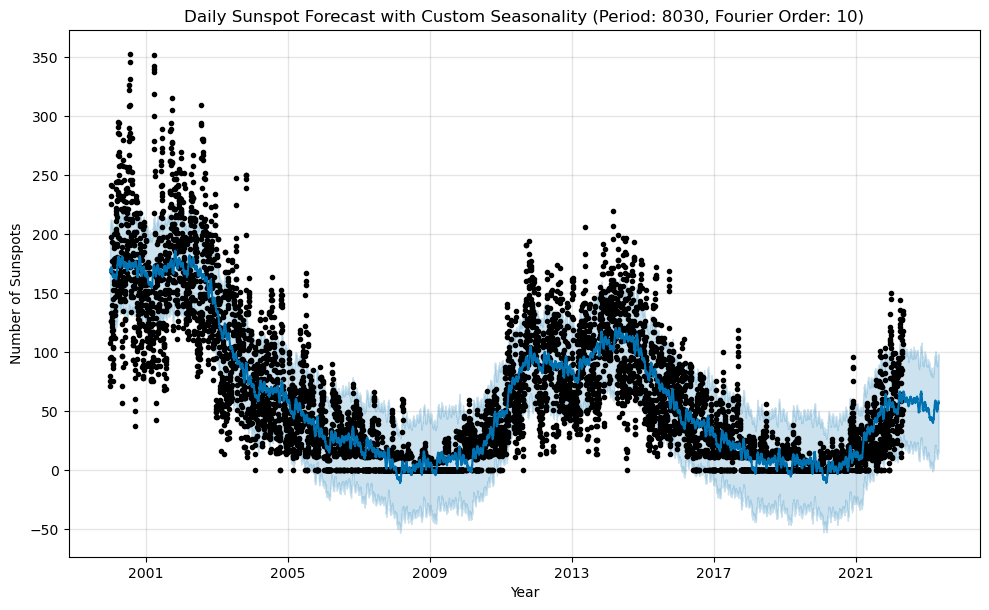


Forecast for Period: 8030 days, Fourier Order: 10
             ds       yhat
8516 2023-04-26  55.951012
8517 2023-04-27  56.526522
8518 2023-04-28  56.951727
8519 2023-04-29  56.238939
8520 2023-04-30  57.996635


16:59:00 - cmdstanpy - INFO - Chain [1] start processing
16:59:01 - cmdstanpy - INFO - Chain [1] done processing


<Figure size 1200x600 with 0 Axes>

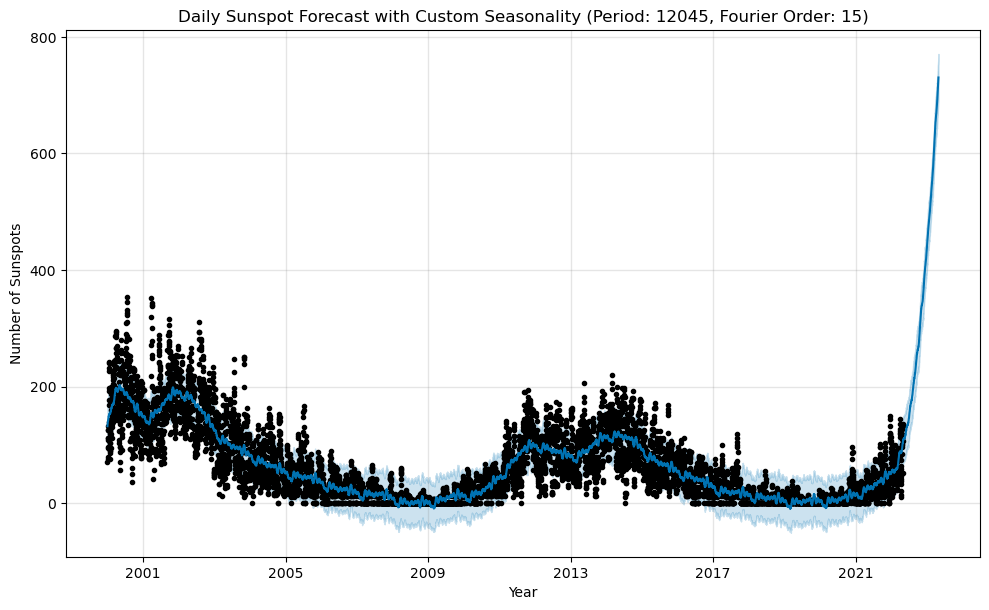


Forecast for Period: 12045 days, Fourier Order: 15
             ds        yhat
8516 2023-04-26  717.733663
8517 2023-04-27  720.921733
8518 2023-04-28  723.964156
8519 2023-04-29  725.902798
8520 2023-04-30  730.317108


16:59:04 - cmdstanpy - INFO - Chain [1] start processing
16:59:05 - cmdstanpy - INFO - Chain [1] done processing


<Figure size 1200x600 with 0 Axes>

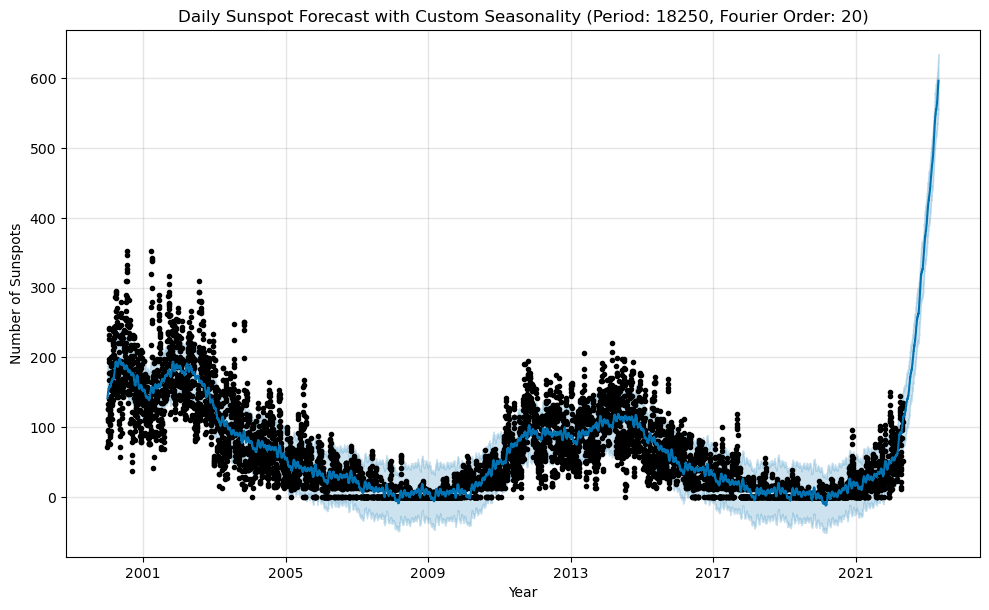


Forecast for Period: 18250 days, Fourier Order: 20
             ds        yhat
8516 2023-04-26  587.864050
8517 2023-04-27  590.093964
8518 2023-04-28  592.176266
8519 2023-04-29  593.144553
8520 2023-04-30  596.599129


In [6]:
import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt

# Load the daily dataset
daily_dataset = pd.read_csv('C:/Users/harin/OneDrive/Desktop/MS DS College stuffs/CS675 Intro To DS/Assignment 3/SN_d_tot_V2.0.csv', header=None, 
                            names=['Year', 'Month', 'Day', 'DecimalDate', 'Sunspots', 'StdDev', 'Observations', 'Indicator'], 
                            sep=';')

# Create a datetime column from Year, Month, and Day
daily_dataset['ds'] = pd.to_datetime(daily_dataset[['Year', 'Month', 'Day']])
daily_dataset['y'] = daily_dataset['Sunspots']

# Replace missing values (-1) with NaN and drop rows with NaN values
daily_dataset['y'].replace(-1, pd.NA, inplace=True)
daily_dataset.dropna(subset=['y'], inplace=True)

# Filter the dataset to include only data from the year 2000 onwards
df = daily_dataset[daily_dataset['ds'] >= '2000-01-01'][['ds', 'y']]

# Function to create forecast with custom seasonality
def create_forecast_with_seasonality(period, fourier_order):
    m = Prophet(daily_seasonality=True)
    m.add_seasonality(name=f'custom_{period}', period=period, fourier_order=fourier_order)
    m.fit(df)
    
    future = m.make_future_dataframe(periods=365, freq='D')
    forecast = m.predict(future)
    
    plt.figure(figsize=(12, 6))
    m.plot(forecast)
    plt.title(f'Daily Sunspot Forecast with Custom Seasonality (Period: {period}, Fourier Order: {fourier_order})')
    plt.xlabel('Year')
    plt.ylabel('Number of Sunspots')
    plt.show()
    
    return forecast

# Test different combinations
period_fourier_combinations = [
    (365, 5),    # Approximately one year
    (365*11, 7), # Approximately one solar cycle (11 years)
    (365*22, 10),# Approximately two solar cycles
    (365*33, 15),# Approximately three solar cycles
    (365*50, 20) # Longer-term cycle (50 years)
]

for period, fourier_order in period_fourier_combinations:
    forecast = create_forecast_with_seasonality(period, fourier_order)
    print(f"\nForecast for Period: {period} days, Fourier Order: {fourier_order}")
    print(forecast[['ds', 'yhat']].tail())

Trend Changepoints

The use of changepoints allows the model to adjust to sudden shifts in the trend of sunspot activity. 
By adjusting the number of changepoints and the changepoint prior scale, you can control how flexible the trend changes are. 
Higher values for n_changepoints and changepoint_prior_scale allow the model to capture more abrupt shifts in the sunspot cycle

C:\Users\harin\AppData\Local\Temp\ipykernel_38244\379413785.py:15: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  daily_dataset['y'].replace(-1, pd.NA, inplace=True)
17:01:00 - cmdstanpy - INFO - Chain [1] start processing
17:01:01 - cmdstanpy - INFO - Chain [1] done processing


<Figure size 1200x600 with 0 Axes>

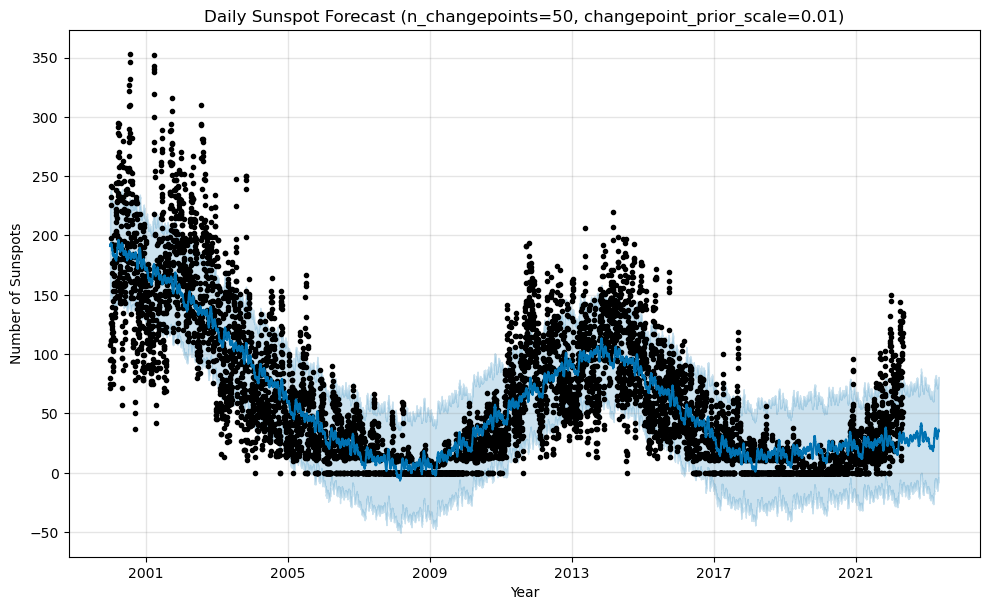

17:01:04 - cmdstanpy - INFO - Chain [1] start processing
17:01:08 - cmdstanpy - INFO - Chain [1] done processing


<Figure size 1200x600 with 0 Axes>

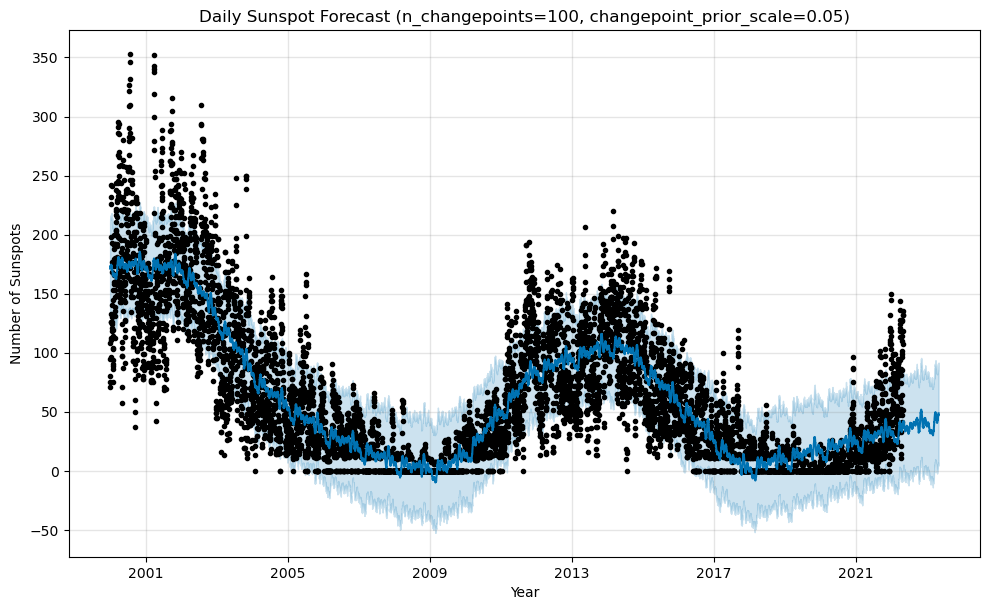

17:01:11 - cmdstanpy - INFO - Chain [1] start processing
17:01:23 - cmdstanpy - INFO - Chain [1] done processing


<Figure size 1200x600 with 0 Axes>

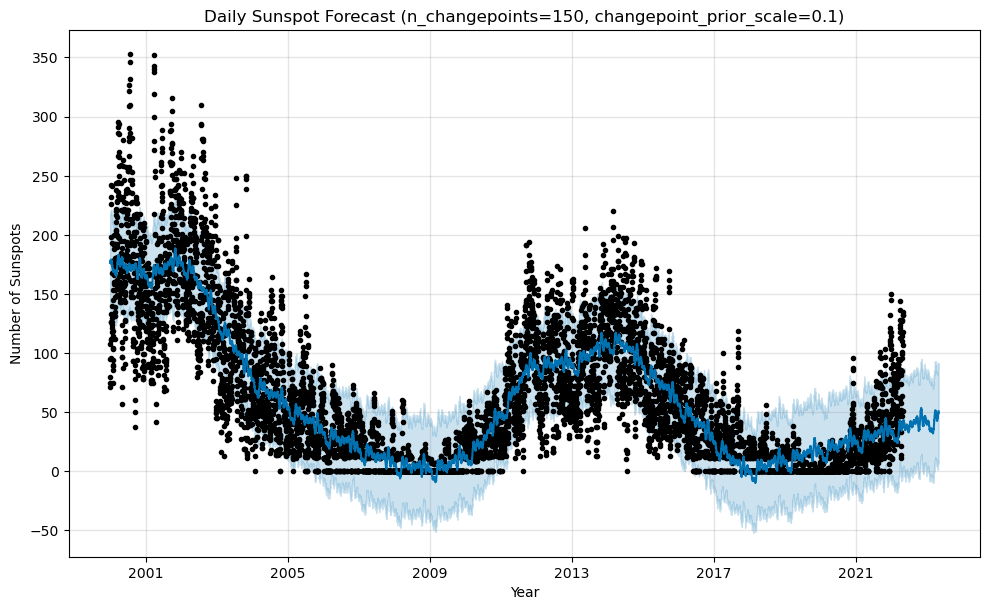

17:01:25 - cmdstanpy - INFO - Chain [1] start processing
17:02:28 - cmdstanpy - INFO - Chain [1] done processing


<Figure size 1200x600 with 0 Axes>

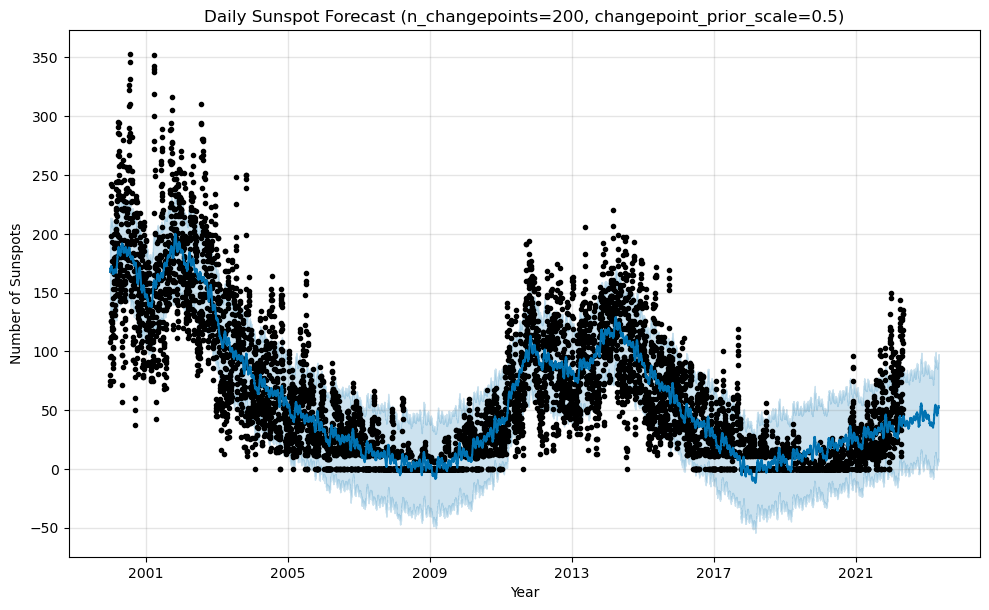

17:02:30 - cmdstanpy - INFO - Chain [1] start processing
17:03:42 - cmdstanpy - INFO - Chain [1] done processing


<Figure size 1200x600 with 0 Axes>

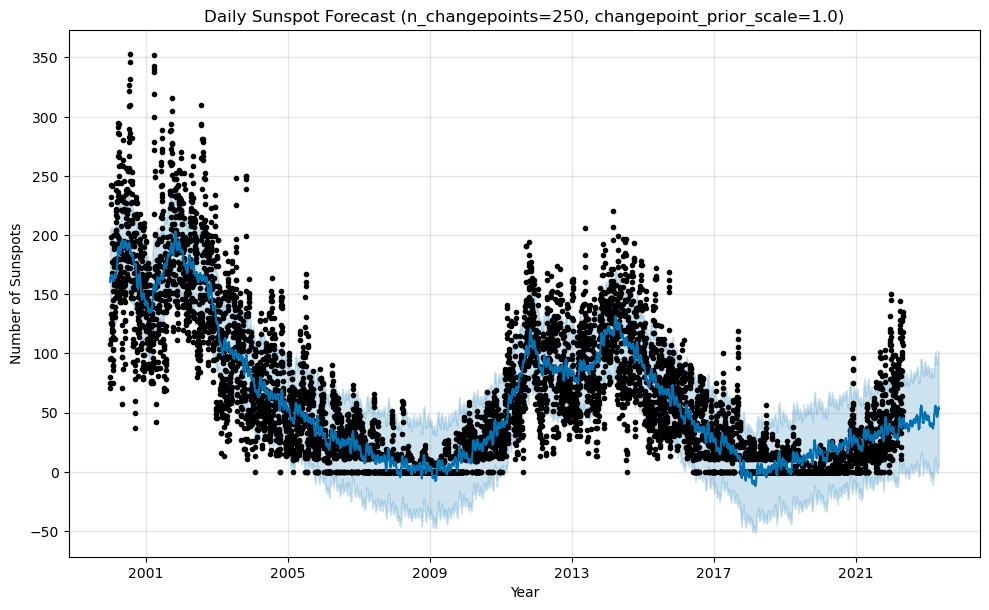


Forecast for n_changepoints=50, changepoint_prior_scale=0.01
             ds       yhat
8516 2023-04-26  34.538554
8517 2023-04-27  35.042459
8518 2023-04-28  35.392876
8519 2023-04-29  34.583045
8520 2023-04-30  36.234826

Forecast for n_changepoints=100, changepoint_prior_scale=0.05
             ds       yhat
8516 2023-04-26  46.778612
8517 2023-04-27  47.307662
8518 2023-04-28  47.683751
8519 2023-04-29  46.916773
8520 2023-04-30  48.601070

Forecast for n_changepoints=150, changepoint_prior_scale=0.1
             ds       yhat
8516 2023-04-26  48.829788
8517 2023-04-27  49.365197
8518 2023-04-28  49.747776
8519 2023-04-29  48.983105
8520 2023-04-30  50.675339

Forecast for n_changepoints=200, changepoint_prior_scale=0.5
             ds       yhat
8516 2023-04-26  51.557042
8517 2023-04-27  52.085611
8518 2023-04-28  52.461322
8519 2023-04-29  51.696352
8520 2023-04-30  53.381679

Forecast for n_changepoints=250, changepoint_prior_scale=1.0
             ds       yhat
8516 2023-04-2

In [7]:
import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt

# Load the daily dataset
daily_dataset = pd.read_csv('C:/Users/harin/OneDrive/Desktop/MS DS College stuffs/CS675 Intro To DS/Assignment 3/SN_d_tot_V2.0.csv', header=None, 
                            names=['Year', 'Month', 'Day', 'DecimalDate', 'Sunspots', 'StdDev', 'Observations', 'Indicator'], 
                            sep=';')

# Create a datetime column from Year, Month, and Day
daily_dataset['ds'] = pd.to_datetime(daily_dataset[['Year', 'Month', 'Day']])
daily_dataset['y'] = daily_dataset['Sunspots']

# Replace missing values (-1) with NaN and drop rows with NaN values
daily_dataset['y'].replace(-1, pd.NA, inplace=True)
daily_dataset.dropna(subset=['y'], inplace=True)

# Filter the dataset to include only data from the year 2000 onwards
df = daily_dataset[daily_dataset['ds'] >= '2000-01-01'][['ds', 'y']]

# Function to create forecast with changepoints
def create_forecast_with_changepoints(n_changepoints, changepoint_prior_scale):
    m = Prophet(n_changepoints=n_changepoints, changepoint_prior_scale=changepoint_prior_scale, daily_seasonality=True)
    m.fit(df)
    
    future = m.make_future_dataframe(periods=365, freq='D')  # Forecasting for 1 year ahead (daily)
    forecast = m.predict(future)
    
    fig = plt.figure(figsize=(12, 6))
    m.plot(forecast)
    plt.title(f'Daily Sunspot Forecast (n_changepoints={n_changepoints}, changepoint_prior_scale={changepoint_prior_scale})')
    plt.xlabel('Year')
    plt.ylabel('Number of Sunspots')
    plt.show()
    
    return forecast

# Test different combinations
changepoint_combinations = [
    (50, 0.01),
    (100, 0.05),
    (150, 0.1),
    (200, 0.5),
    (250, 1.0)
]

forecasts = []  # To store all forecasts

for n_changepoints, changepoint_prior_scale in changepoint_combinations:
    forecast = create_forecast_with_changepoints(n_changepoints, changepoint_prior_scale)
    forecasts.append((n_changepoints, changepoint_prior_scale, forecast[['ds', 'yhat']].tail()))

# Print the last 5 days of predictions for each configuration
for n_changepoints, changepoint_prior_scale, forecast in forecasts:
    print(f"\nForecast for n_changepoints={n_changepoints}, changepoint_prior_scale={changepoint_prior_scale}")
    print(forecast)

Evaluate all models by providing their respective MAE (Mean Absolute Error) and MAPE (Mean Absolute Percentage Error), as well as R2



C:\Users\harin\AppData\Local\Temp\ipykernel_38244\864404694.py:18: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  daily_dataset['y'].replace(-1, pd.NA, inplace=True)


Evaluating Test Case 1: {'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}


17:09:10 - cmdstanpy - INFO - Chain [1] start processing
17:09:12 - cmdstanpy - INFO - Chain [1] done processing


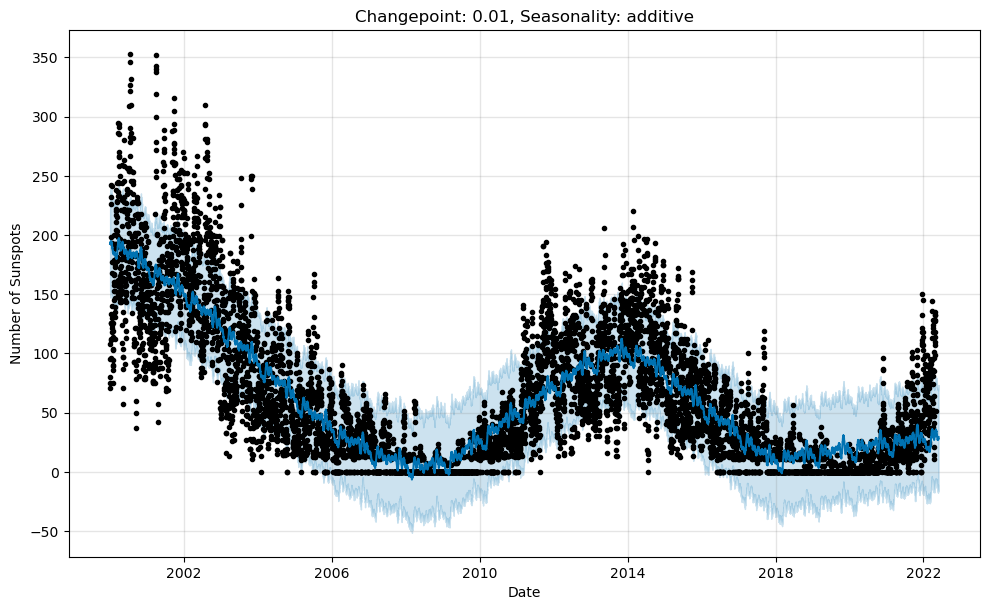

Evaluating Test Case 2: {'changepoint_prior_scale': 0.1, 'seasonality_mode': 'multiplicative'}


17:09:14 - cmdstanpy - INFO - Chain [1] start processing
17:09:19 - cmdstanpy - INFO - Chain [1] done processing


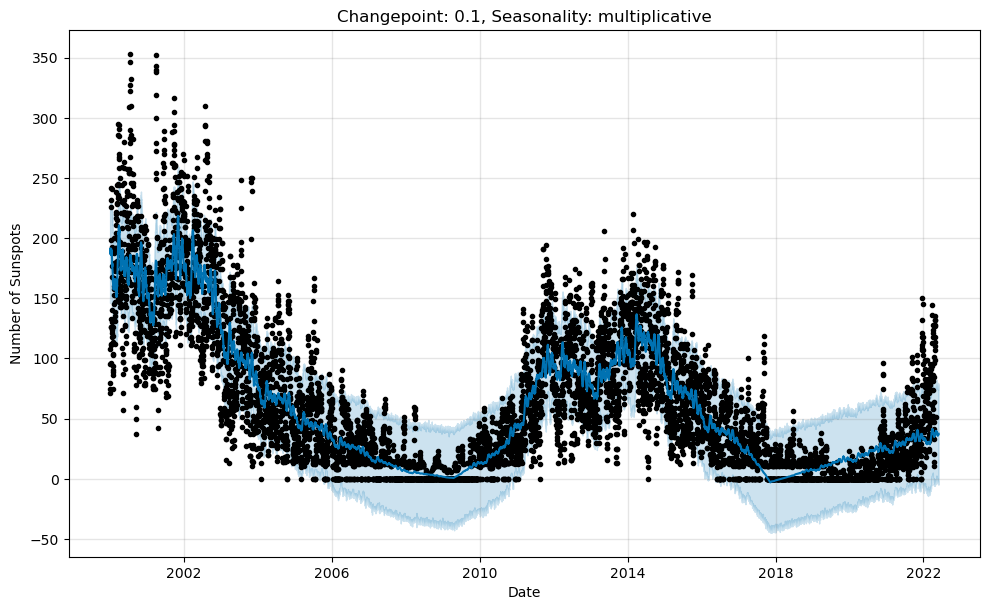

Evaluating Test Case 3: {'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}


17:09:21 - cmdstanpy - INFO - Chain [1] start processing
17:09:23 - cmdstanpy - INFO - Chain [1] done processing


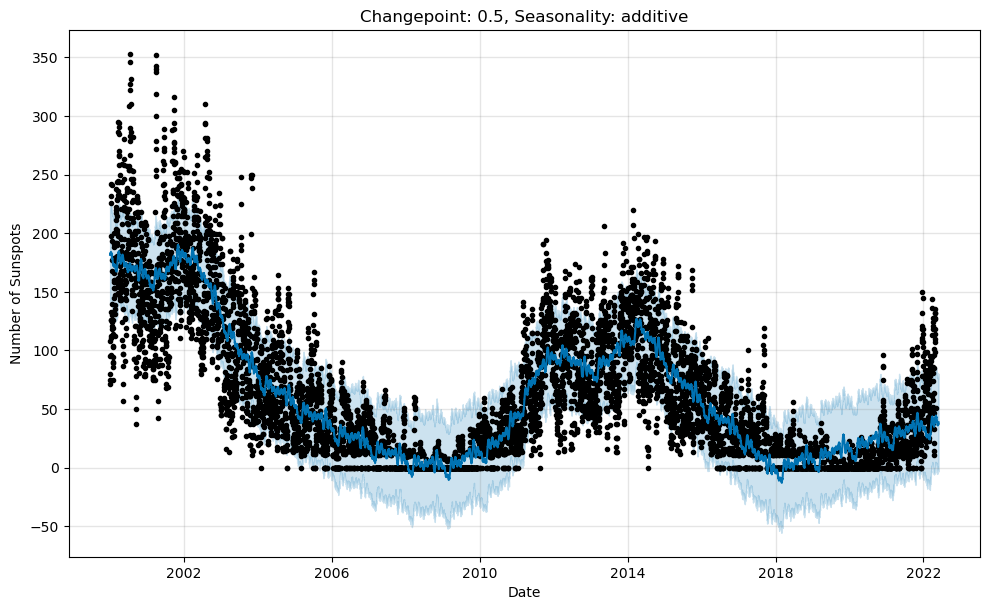

Evaluating Test Case 4: {'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


17:09:26 - cmdstanpy - INFO - Chain [1] start processing
17:09:29 - cmdstanpy - INFO - Chain [1] done processing


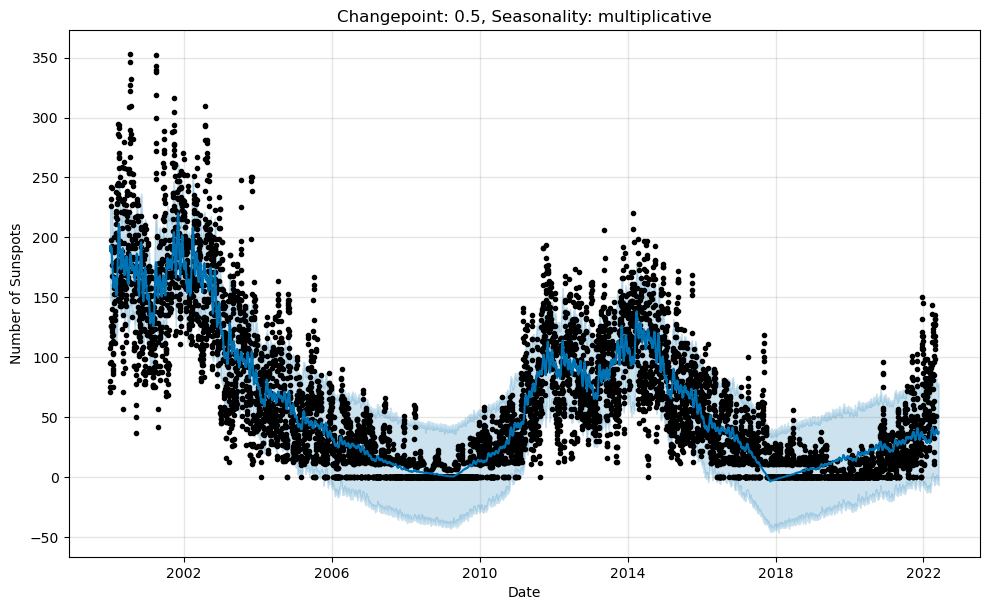


Test Case 1 Results:
MAE: 24.39
MAPE: 1462488548092255488.00%
R²: 0.7136

Test Case 2 Results:
MAE: 22.35
MAPE: 1067125527162542592.00%
R²: 0.7554

Test Case 3 Results:
MAE: 22.78
MAPE: 1155437269719727360.00%
R²: 0.7475

Test Case 4 Results:
MAE: 22.33
MAPE: 1065772615842845824.00%
R²: 0.7556


In [10]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, r2_score
from prophet import Prophet
import matplotlib.pyplot as plt

# Load the dataset
file_path = 'C:/Users/harin/OneDrive/Desktop/MS DS College stuffs/CS675 Intro To DS/Assignment 3/SN_d_tot_V2.0.csv'  # Replace with your daily dataset path
daily_dataset = pd.read_csv(file_path, header=None, 
                            names=['Year', 'Month', 'Day', 'DecimalDate', 'Sunspots', 'StdDev', 'Observations', 'Indicator'], 
                            sep=';')

# Create a datetime column from Year, Month, and Day
daily_dataset['ds'] = pd.to_datetime(daily_dataset[['Year', 'Month', 'Day']])
daily_dataset['y'] = daily_dataset['Sunspots']

# Replace missing values (-1) with NaN and drop rows with NaN values
daily_dataset['y'].replace(-1, pd.NA, inplace=True)
daily_dataset.dropna(subset=['y'], inplace=True)

# Filter the dataset to include only data from the year 2000 onwards
dataset = daily_dataset[daily_dataset['ds'] >= '2000-01-01'][['ds', 'y']]

# Define test cases with changepoint and seasonality settings
test_cases = [
    {"changepoint_prior_scale": 0.01, "seasonality_mode": "additive"},
    {"changepoint_prior_scale": 0.1, "seasonality_mode": "multiplicative"},
    {"changepoint_prior_scale": 0.5, "seasonality_mode": "additive"},
    {"changepoint_prior_scale": 0.5, "seasonality_mode": "multiplicative"},
]

# Function to evaluate a Prophet model
def evaluate_prophet_model(params, dataset):
    # Initialize and fit the model with parameters
    model = Prophet(
        changepoint_prior_scale=params["changepoint_prior_scale"],
        seasonality_mode=params["seasonality_mode"],
        daily_seasonality=True
    )
    model.fit(dataset)

    # Make future dataframe (30 days ahead for prediction)
    future = model.make_future_dataframe(periods=30, freq='D')
    forecast = model.predict(future)

    # Split predictions into actuals and forecasts
    forecast_actuals = forecast[forecast['ds'] <= dataset['ds'].max()]
    forecast_future = forecast[forecast['ds'] > dataset['ds'].max()]

    # Calculate evaluation metrics on historical data
    y_true = dataset['y'].values
    y_pred = forecast_actuals['yhat'].values
    mae = mean_absolute_error(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred) * 100
    r2 = r2_score(y_true, y_pred)

    # Plot results
    model.plot(forecast)
    plt.title(f"Changepoint: {params['changepoint_prior_scale']}, Seasonality: {params['seasonality_mode']}")
    plt.xlabel('Date')
    plt.ylabel('Number of Sunspots')
    plt.show()

    return {"MAE": mae, "MAPE": mape, "R²": r2, "future_forecast": forecast_future[['ds', 'yhat']]}

# Evaluate all test cases
results = {}
for i, params in enumerate(test_cases):
    print(f"Evaluating Test Case {i + 1}: {params}")
    results[f"Test Case {i + 1}"] = evaluate_prophet_model(params, dataset)

# Display results
for key, metrics in results.items():
    print(f"\n{key} Results:")
    print(f"MAE: {metrics['MAE']:.2f}")
    print(f"MAPE: {metrics['MAPE']:.2f}%")
    print(f"R²: {metrics['R²']:.4f}")